In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm
from scipy.special import gamma
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2

### Let's try to expand the chiral hydrogen state...

In [4]:
def R_42(r, In):
    kappa = np.sqrt(2*In)
    return (2*kappa)**(3/2+2) * 1/np.sqrt(5760) * r**2 * np.exp(-kappa*r) * (-2*kappa*r+6)

def R_43(r, In):
    kappa = np.sqrt(2*In)
    return (2*kappa)**(3/2+3) * 1/np.sqrt(40320) * r**3 * np.exp(-kappa*r)

def hyd_4d(r, theta, phi, m, Z):
    In = Z**2 / (2*4**2)
    return R_42(r, In) * sph_harm(m, 2, phi, theta)

def hyd_4f(r, theta, phi, m, Z):
    In = Z**2 / (2*4**2)
    return R_43(r, In) * sph_harm(m, 3, phi, theta)

def hyd_rho(r, theta, phi, pm, Z):
    return 0.5 * (hyd_4d(r, theta, phi, pm, Z) + 1j*hyd_4f(r, theta, phi, pm, Z) - hyd_4d(r, theta, phi, -pm, Z) + 1j*hyd_4f(r, theta, phi, -pm, Z))

Ip = 0.579
Z = 4*np.sqrt(2*Ip)
kappa = np.sqrt(2 * Ip)  # This is kappa for the n=4 state, given that Z is as above

rho_p = lambda r, theta, phi : hyd_rho(r, theta, phi, 1, Z)
rho_m = lambda r, theta, phi : hyd_rho(r, theta, phi, -1, Z)

In [5]:
n_r = 100
r_lst = np.linspace(1, 20, n_r)
flms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    flms.append(se.spherical_expansion(lambda theta, phi: rho_p(r, theta, phi), 50))

Evaluating at r=1.0000 	 Nr. 1/100
Evaluating at r=1.1919 	 Nr. 2/100
Evaluating at r=1.3838 	 Nr. 3/100
Evaluating at r=1.5758 	 Nr. 4/100
Evaluating at r=1.7677 	 Nr. 5/100
Evaluating at r=1.9596 	 Nr. 6/100
Evaluating at r=2.1515 	 Nr. 7/100
Evaluating at r=2.3434 	 Nr. 8/100
Evaluating at r=2.5354 	 Nr. 9/100
Evaluating at r=2.7273 	 Nr. 10/100
Evaluating at r=2.9192 	 Nr. 11/100
Evaluating at r=3.1111 	 Nr. 12/100
Evaluating at r=3.3030 	 Nr. 13/100
Evaluating at r=3.4949 	 Nr. 14/100
Evaluating at r=3.6869 	 Nr. 15/100
Evaluating at r=3.8788 	 Nr. 16/100
Evaluating at r=4.0707 	 Nr. 17/100
Evaluating at r=4.2626 	 Nr. 18/100
Evaluating at r=4.4545 	 Nr. 19/100
Evaluating at r=4.6465 	 Nr. 20/100
Evaluating at r=4.8384 	 Nr. 21/100
Evaluating at r=5.0303 	 Nr. 22/100
Evaluating at r=5.2222 	 Nr. 23/100
Evaluating at r=5.4141 	 Nr. 24/100
Evaluating at r=5.6061 	 Nr. 25/100
Evaluating at r=5.7980 	 Nr. 26/100
Evaluating at r=5.9899 	 Nr. 27/100
Evaluating at r=6.1818 	 Nr. 28/100
E

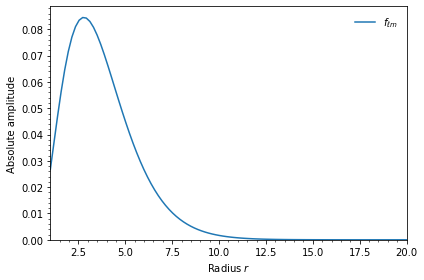

In [6]:
plt.figure(facecolor='white')

def radial(r, kappa):
    return r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 1,3,1
#plt.plot(r_lst, np.array([output.eval_orbital_spherical(r, np.pi/2, 0) for r in r_lst])*100, label=r'$\psi_0$')
#plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m])/radial(r_lst, kappa), label=r'$c_{\ell m}$')
plt.plot(r_lst, np.abs(np.array(flms)[:, sgn, l, m]),  label=r'$f_{\ell m}$')
plt.legend(frameon=False)
plt.xlabel(r'Radius $r$')
plt.ylabel(r'Absolute amplitude')
plt.minorticks_on()
plt.xlim(r_lst[0], r_lst[-1])
plt.ylim(bottom=0)
plt.tight_layout()

Evaluating at r=20.0000 	 Nr. 50/50
Now fitting!
Done!


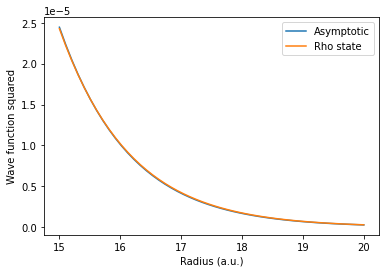

In [6]:
r_list = np.linspace(15, 20, 50)
#clm_array = se.get_asymp_fit(lambda r, theta, phi : hyd_rho(r, theta, phi, 1.), r_list, 10, Ip, threshold=1e-6)
clm_array = se.get_asymp_fit(rho_p, r_list, 10, Ip, Z=Z, threshold=1e-10)

phi = 0
theta = 0.3#np.pi/2

plt.figure(facecolor='white')
plt.plot(r_list, np.abs(se.eval_asymptotic(r_list, theta, phi, clm_array, Ip, Z=Z)), label='Asymptotic')
plt.plot(r_list, np.abs(rho_p(r_list, theta, phi)), label='Rho state')

plt.legend()
plt.xlabel('Radius (a.u.)')
plt.ylabel('Wave function squared')
plt.show()

In [5]:
def make_CQSFA_coeff_file(clm_array, file_name):
    clm_list = se.convert_clm_array_to_list(clm_array)
    print(file_name)
    with open(file_name + '.txt', 'w') as file:
        for coeff in clm_list:
            file.write(f'{coeff.real} {coeff.imag}\n')

In [8]:
r_list = np.linspace(15, 20, 10)
clm_array = se.get_asymp_fit(rho_p, r_list, 8, Ip, Z=Z, threshold=1e-6)
clm_array_chiral = se.get_asymp_fit(rho_m, r_list, 8, Ip, Z=Z, threshold=1e-6)#se.mirror_clm_xz(clm_array)

#make_CQSFA_coeff_file(clm_array, 'hyd_asymp')
#make_CQSFA_coeff_file(clm_array_chiral, 'hyd_asymp_chiral')

print(clm_array[0,2,1], clm_array[0,3,1])
print(clm_array[1,2,1], clm_array[1,3,1])

Evaluating at r=20.0000 	 Nr. 10/10
Now fitting!
Done!
Evaluating at r=20.0000 	 Nr. 10/10
Now fitting!
Done!
(-0.16961344506217127+3.853623956418661e-17j) (1.595129871436579e-17+0.07837706236380605j)
(0.16961344506312775+3.048165106751276e-17j) (-1.479683572865018e-17+0.07837706236380604j)


In [8]:
np.save('data/rho_state/clm_array_chiral', clm_array_chiral)

In [37]:
from mayavi import mlab
def plot_wavefunc(clm_array, iso=0.03, l=5, n=100):
    x, y, z = np.mgrid[-l:l:n*1j, -l:l:n*1j, -l:l:n*1j]
    mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
    orbital = np.real(se.eval_asymptotic_cart(x, y, z, clm_array, Ip))

    mlab.contour3d(orbital, contours=[iso], transparent=False, color=(1, 0, 0))
    mlab.contour3d(orbital, contours=[-iso], transparent=False, color=(0, 0, 1))
    mlab.show()

plot_wavefunc(clm_array_chiral,iso=1e-4, l=30, n=100)

In [34]:
N = 75
pz_list = np.linspace(-1., 1., 2*N)
px_list = np.linspace(0., 0.8, N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.
CEP_list = np.linspace(0, 2*np.pi, 21)[:-1]

SP_list = [SFA_Lin.SFALinearPulse(Ip, Up, omega, 10, CEPi, Z_=Z, target_="asymp_martiny") for CEPi in CEP_list]
M_grid_list = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))) for SPi in SP_list]
M_grid_CEP = np.mean(np.abs(M_grid_list)**2, axis=0)
#np.save(save_path + 'M_CEP_array', M_grid_list)
#np.save(save_path + 'M_CEP', M_grid_CEP)

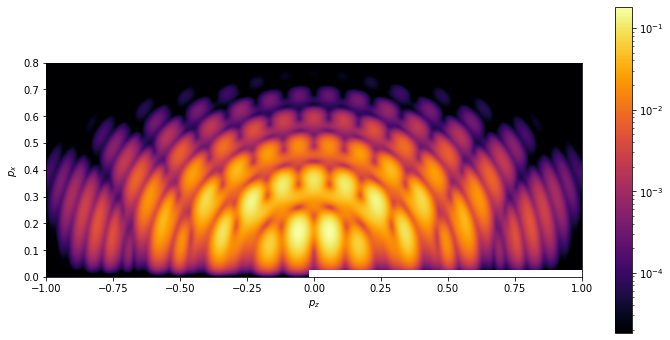

In [35]:
plt.figure(facecolor='white', figsize=(12,6))

MMax = np.max(M_grid_CEP)

plt.imshow(np.flip(M_grid_CEP,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='inferno', norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

In [36]:
SP_OAM_list = []
SP_OAM_chiral = []
for CEPi in CEP_list:
    SP_temp = SFA_Lin.SFALinearPulse(Ip, Up, omega, 10, CEPi, Z_=Z, target_="asymp_martiny")
    SP_temp.OAM = 1
    SP_OAM_list.append(SP_temp)
    #SP_temp = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEPi, Z_=Z, target_="asymp_martiny")
    #SP_temp.OAM = -1
    #SP_OAM_chiral.append(SP_temp)

OAM_CEP_list = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))) for SPi in SP_OAM_list]
OAM_CEP_list_chiral = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_chiral)))) for SPi in SP_OAM_list]
#OAM_CEP_list_chiral = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))) for SPi in SP_OAM_chiral]
OAM_CEP = np.mean(np.abs(OAM_CEP_list)**2, axis=0)
OAM_CEP_chiral = np.mean(np.abs(OAM_CEP_list_chiral)**2, axis=0)

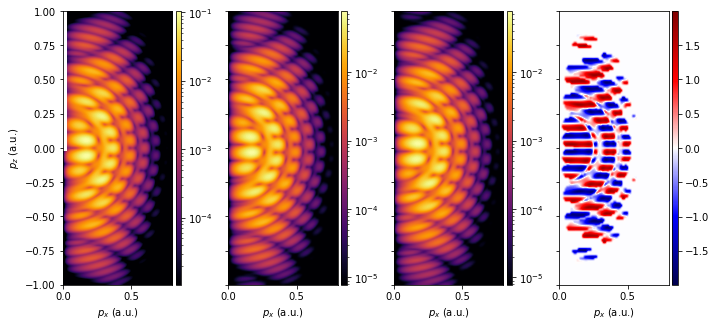

In [44]:
fig, axs = plt.subplots(1,4, figsize=(10,5), facecolor='white', sharey=True)
log_lim = 1e-4

OAM2_p = OAM_CEP
OAM2_m = OAM_CEP_chiral

MMax = np.max(M_grid_CEP)
OAM_max = np.max(OAM2_m)

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD,nan=0)
filter_list = M_grid_CEP > MMax * 0.02
PEVD[np.logical_not(filter_list)] = 0

np.save('asymp_SFA_PEVD_10', PEVD)

OAM_max = np.max(OAM2_m)
OAM2_m[OAM2_m < OAM_max*log_lim] = OAM_max*log_lim
OAM2_p[OAM2_p < OAM_max*log_lim] = OAM_max*log_lim


im = axs[0].imshow(np.flip(M_grid_CEP,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='inferno', norm=LogNorm(vmin=MMax*log_lim, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

axs[0].set_ylabel("$p_z$ (a.u.)")
axs[0].set_xlabel("$p_x$ (a.u.)")
#axs[0].colorbar(im, ax=ax, shrink=0.6)

im1 = axs[1].imshow(np.flip(OAM2_m,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='inferno', norm=LogNorm(vmin=OAM_max*log_lim, vmax=OAM_max),
           interpolation = 'bicubic', aspect = 1.)
axs[1].set_xlabel("$p_x$ (a.u.)")

im2 = axs[2].imshow(np.flip(OAM2_p,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='inferno', norm=LogNorm(vmin=OAM_max*log_lim, vmax=OAM_max),
           interpolation = 'bicubic', aspect = 1.)
axs[2].set_xlabel("$p_x$ (a.u.)")

im3 = axs[3].imshow(np.flip(PEVD,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)
axs[3].set_xlabel("$p_x$ (a.u.)")

divider0 = make_axes_locatable(axs[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax0, orientation='vertical')

divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

divider3 = make_axes_locatable(axs[3])
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')

#fig.colorbar(im2, ax=axs[3])
#fig.colorbar(im3, ax=axs[4])
plt.tight_layout()
#plt.savefig(save_path + 'norcamphor_SFA_PEVD_CEP.png', dpi=300, bbox_inches='tight')

### Old stuff

In [41]:
N = 75
pz_list = np.linspace(-1., 1., 2*N)
px_list = np.linspace(0., 0.8, N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.
CEP_list = np.linspace(0, 2*np.pi, 15)[:-1]

#SP_list = [SFA_Lin.SFALinearPulse(0.579, Up, omega, 2, CEPi, target_="asymp_hyd_rho") for CEPi in CEP_list]

SP_list = [SFA_Lin.SFALinearPulse(Ip, Up, omega, 10, CEPi, Z_=Z, target_="rho_test") for CEPi in CEP_list]
M_grid_list = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))) for SPi in SP_list]
M_grid_CEP = np.mean(np.abs(M_grid_list)**2, axis=0)
#np.save(save_path + 'M_CEP_array', M_grid_list)
#np.save(save_path + 'M_CEP', M_grid_CEP)

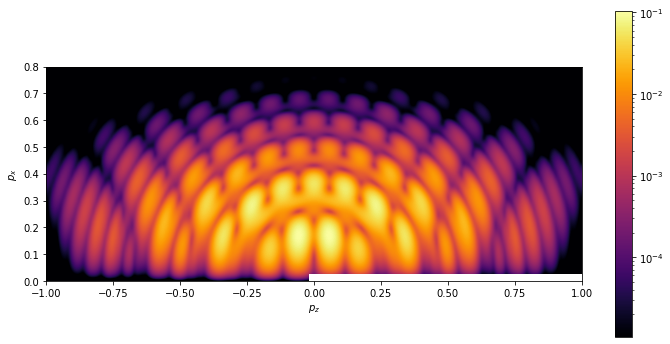

In [42]:
plt.figure(facecolor='white', figsize=(12,6))

MMax = np.max(M_grid_CEP)

plt.imshow(np.flip(M_grid_CEP,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='inferno', norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

In [20]:
SP_OAM_list = []
SP_OAM_chiral = []
for CEPi in CEP_list:
    SP_temp = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEPi, Z_=Z, target_="rho_test")
    SP_temp.OAM = 1
    SP_OAM_list.append(SP_temp)
    SP_temp = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEPi, Z_=Z, target_="rho_test")
    SP_temp.OAM = -1
    SP_OAM_chiral.append(SP_temp)

OAM_CEP_list = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))) for SPi in SP_OAM_list]
#OAM_CEP_list_chiral = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_chiral)))) for SPi in SP_OAM_list]
OAM_CEP_list_chiral = [np.array(pool.starmap(SPi.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_chiral)))) for SPi in SP_OAM_chiral]
OAM_CEP = np.mean(np.abs(OAM_CEP_list)**2, axis=0)
OAM_CEP_chiral = np.mean(np.abs(OAM_CEP_list_chiral)**2, axis=0)

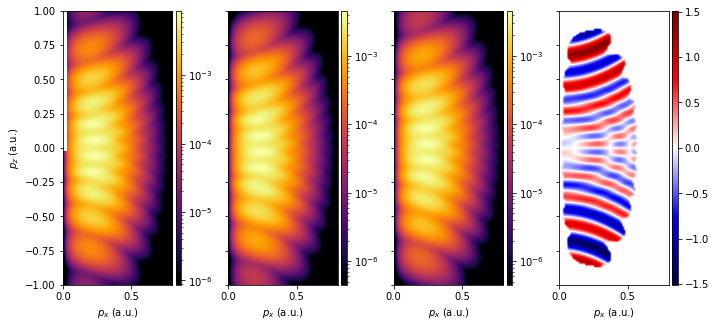

In [24]:
fig, axs = plt.subplots(1,4, figsize=(10,5), facecolor='white', sharey=True)
log_lim = 1e-4

OAM2_p = OAM_CEP
OAM2_m = OAM_CEP_chiral

MMax = np.max(M_grid_CEP)
OAM_max = np.max(OAM2_m)

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD,nan=0)
filter_list = M_grid_CEP > MMax * 0.02
PEVD[np.logical_not(filter_list)] = 0

np.save('SFA_PEVD', PEVD)

OAM_max = np.max(OAM2_m)
OAM2_m[OAM2_m < OAM_max*log_lim] = OAM_max*log_lim
OAM2_p[OAM2_p < OAM_max*log_lim] = OAM_max*log_lim


im = axs[0].imshow(np.flip(M_grid_CEP,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='inferno', norm=LogNorm(vmin=MMax*log_lim, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

axs[0].set_ylabel("$p_z$ (a.u.)")
axs[0].set_xlabel("$p_x$ (a.u.)")
#axs[0].colorbar(im, ax=ax, shrink=0.6)

im1 = axs[1].imshow(np.flip(OAM2_m,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='inferno', norm=LogNorm(vmin=OAM_max*log_lim, vmax=OAM_max),
           interpolation = 'bicubic', aspect = 1.)
axs[1].set_xlabel("$p_x$ (a.u.)")

im2 = axs[2].imshow(np.flip(OAM2_p,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='inferno', norm=LogNorm(vmin=OAM_max*log_lim, vmax=OAM_max),
           interpolation = 'bicubic', aspect = 1.)
axs[2].set_xlabel("$p_x$ (a.u.)")

im3 = axs[3].imshow(np.flip(PEVD,1).T, extent = (np.amin(px_list), np.amax(px_list), np.amin(pz_list), np.amax(pz_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)
axs[3].set_xlabel("$p_x$ (a.u.)")

divider0 = make_axes_locatable(axs[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax0, orientation='vertical')

divider1 = make_axes_locatable(axs[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

divider3 = make_axes_locatable(axs[3])
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')

#fig.colorbar(im2, ax=axs[3])
#fig.colorbar(im3, ax=axs[4])
plt.tight_layout()
#plt.savefig(save_path + 'norcamphor_SFA_PEVD_CEP.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_3578/4076842618.py:19: RuntimeWarning: invalid value encountered in true_divide
  PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))


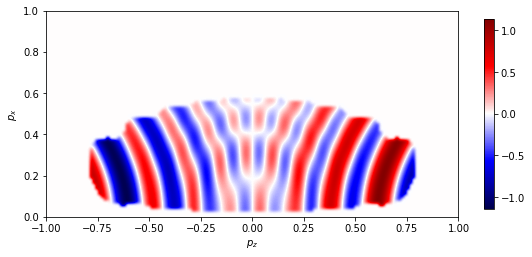

In [20]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="rho_test")

N = 75
pzList = np.linspace(-1., 1., 2*N)
pxList = np.linspace(0, 1., N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

SP.OAM = 1
OAM_p = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(np.array([0., 0., 0.])))))

SP.OAM = -1
OAM_m = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(np.array([0., 0., 0.])))))


OAM2_m = np.abs(OAM_m)**2
OAM2_p = np.abs(OAM_p)**2

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD,nan=0)

filter_list = M2_grid > np.max(M2_grid*0.02)
#filter_list2 = OAM2_p > np.max(OAM2_p*1e-4)
#combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(filter_list)] = 0
#PEVD[np.logical_not(filter_list1)] = 0
#plt.imshow(np.flip(diff_grid.T), cmap='seismic', interpolation='bicubic')

fig, ax = plt.subplots(facecolor='white', figsize=(8,4))

im = ax.imshow(np.flip(PEVD,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")

plt.colorbar(im, ax=ax, shrink=0.75)
plt.tight_layout()
#plt.savefig(save_path + 'norcamphor_PEVD_OAM1.png', dpi=300, bbox_inches='tight')

In [6]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

N = 50
pzList = np.linspace(-1.7, 1.7, 2*N)
pxList = np.linspace(0, 1.7, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))

ERROR! Session/line number was not unique in database. History logging moved to new session 693


NameError: name 'clm_array' is not defined

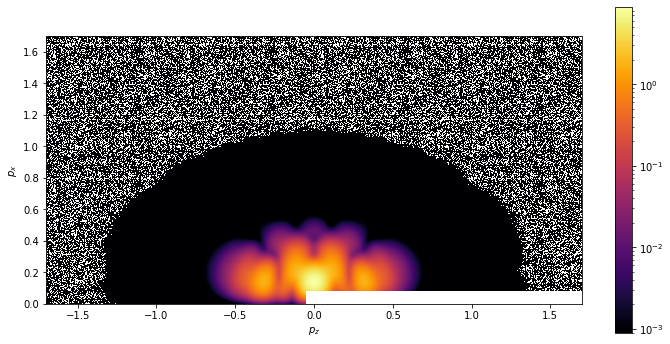

In [32]:
plt.figure(facecolor='white', figsize=(12,6))

M2_grid = np.abs(M_grid)**2
MMax = np.max(M2_grid)

plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='inferno', norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic', aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

### OAM time!

In [10]:
N = 50
pzList = np.linspace(-1.7, 1.7, 2*N)
pxList = np.linspace(0, 1.5, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

clm_array_p = se.get_as_coeffs(rho_p, 40, 30, Ip, abs_thresh=1e-6)
clm_array_m = se.get_as_coeffs(rho_m, 40, 30, Ip, abs_thresh=1e-6)

In [11]:
OAM_list = [-1,1]
OAM_grids = []
rho_grids = []

for i in [1,-1]:
    OAM_grids = []

    for OAM in OAM_list:
        print(f'Calculating for OAM : {OAM}')
        SP.OAM = int(OAM)
        if i == 1:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_p)))))
        else:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_m)))))
    rho_grids.append(OAM_grids[:])

Calculating for OAM : -1
Calculating for OAM : 1
Calculating for OAM : -1
Calculating for OAM : 1


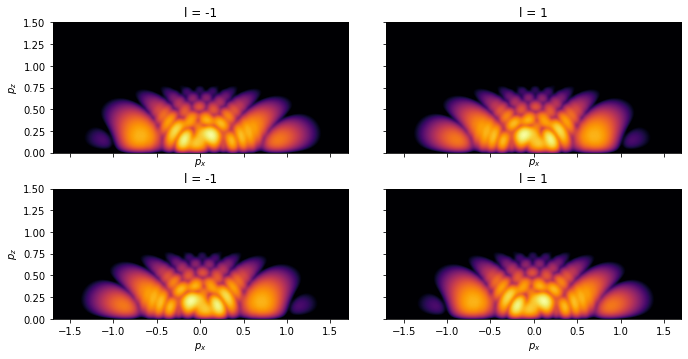

In [12]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex = True, figsize=(10,5), facecolor='white')
plt.tight_layout()
for j, OAM_grids in enumerate(rho_grids):
    for i, Ml_grid in enumerate(OAM_grids):
        Ml2_grid = np.abs(Ml_grid)**2
        Ml_max = np.max(Ml2_grid)
        filter_list = Ml2_grid > np.max(Ml2_grid * 1e-8)
        Ml2_grid[np.logical_not(filter_list)] = 1e-8

        axs[j, i].imshow(np.flip(Ml2_grid,0), cmap='inferno', aspect=1, interpolation = 'bicubic', norm=LogNorm(vmin=Ml_max*1e-4, vmax=Ml_max),
                      extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)))
        axs[j, i].set_title(f'l = {OAM_list[i]}')
        axs[j, i].set_xlabel('$p_x$')

    axs[0,0].set_ylabel('$p_z$')
    axs[1,0].set_ylabel('$p_z$')

plt.tight_layout()

### Looks like it should - -1 for plus is the same as 1 for minus (and the other way around)!

### Now we can calculate the PEVD - do it for just plus state, cause we want high-res!

In [13]:
OAM_list = [-1, 1]

PEVD_grids = []

N = 100
pzList = np.linspace(-1.5, 1.5, 2*N)
pxList = np.linspace(0, 1.4, N)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.

for OAM in OAM_list:
    print(f'Calculating for OAM : {OAM}')
    SP.OAM = int(OAM)
    PEVD_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array_p)))))

Calculating for OAM : -1
Calculating for OAM : 1


In [14]:
OAM_m, OAM_p = PEVD_grids
OAM2_m = np.abs(OAM_m)**2
OAM2_p = np.abs(OAM_p)**2

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD, nan=0)

filter_list1 = OAM2_m > np.max(OAM2_m*1e-4)
filter_list2 = OAM2_p > np.max(OAM2_p*1e-4)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0
#PEVD[np.logical_not(filter_list1)] = 0
#plt.imshow(np.flip(diff_grid.T), cmap='seismic', interpolation='bicubic')

/tmp/ipykernel_20150/3026794779.py:5: RuntimeWarning: invalid value encountered in true_divide
  PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))


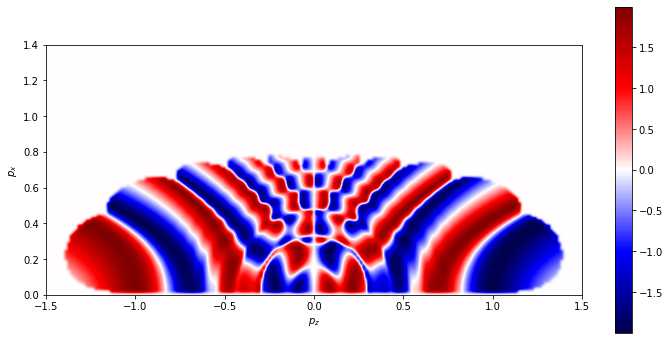

In [15]:
plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()